In [1]:
import numpy as np
import scipy
import pdb
from numba import jit,vectorize,float64, int64,int8

In [2]:
def T_mat_template(kbar):
    kbar2 = 2**kbar
    A = np.zeros((kbar2,kbar2))
    for i in range(kbar2):
        for j in range(i,kbar2-i):
            A[i,j] = np.bitwise_xor(i,j)
    return(A)     

In [3]:
def transition_mat(A,inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones((kbar2,1))
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            prob[i,0] =prob[i,0] * gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    A_ = np.zeros((kbar2,kbar2))
    for i in range(kbar2):
        for m in range(kbar):
            prob[i,0] =prob[i,0]* gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    for i in range(2**(kbar-1)):
        for j in range(i,2**(kbar-1)):
            #pdb.set_trace()
            A_[kbar2-i-1,j] = prob[np.rint(kbar2 - A.copy()[i,j]-1).astype(int),0]
            A_[kbar2-j-1,i] = A_[kbar2-i-1,j]
            A_[j,kbar2-i-1] = A_[kbar2-i-1,j]
            A_[i,kbar2-j-1] = A_[kbar2-i-1,j]
            A_[i,j] = prob[np.rint(A.copy()[i,j]).astype(int),0]
            A_[j,i] = A_[i,j]
            A_[kbar2-j-1,kbar2-i-1] = A_[i,j]
            A_[kbar2-i-1,kbar2-j-1] = A_[i,j]
        
    return(A_)

In [4]:
@jit(float64[:,:](float64[:,:],float64[:],int64))
def transition_mat_jit(A,inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones((kbar2,1))
    A_ = np.zeros((kbar2,kbar2))
    for i in range(kbar2):
        for m in range(kbar):
            prob[i,0] =prob[i,0]* gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    for i in range(2**(kbar-1)):
        for j in range(i,2**(kbar-1)):
            #pdb.set_trace()
            A_[kbar2-i-1,j] = prob[np.rint(kbar2 - A.copy()[i,j]-1).astype(int),0]
            A_[kbar2-j-1,i] = A_[kbar2-i-1,j]
            A_[j,kbar2-i-1] = A_[kbar2-i-1,j]
            A_[i,kbar2-j-1] = A_[kbar2-i-1,j]
            A_[i,j] = prob[np.rint(A.copy()[i,j]).astype(int),0]
            A_[j,i] = A_[i,j]
            A_[kbar2-j-1,kbar2-i-1] = A_[i,j]
            A_[kbar2-i-1,kbar2-j-1] = A_[i,j]
        
    return(A_)


In [5]:
def transition_mat_new(inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    prob = np.ones(kbar2)
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            prob[i] =prob[i] * gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    A = np.fromfunction(lambda i,j: prob[np.bitwise_xor(i,j)],
                          (kbar2,kbar2),dtype = np.uint8)                 
    return(A)

In [6]:
@jit(float64[:,:](float64[:],int64))
def transition_mat_new_jit(inpt,kbar):
    b = inpt[0]
    gamma_kbar = inpt[2]
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,1]
    kbar2 = 2**kbar
    A = np.zeros((kbar2,kbar2))
    prob = np.ones(kbar2)
    # all combination of probabilities from gamma_1*gamma_2*gamma_3, gamma_1*gamma_2*(1-gamma_3),...
    for i in range(kbar2):
        for m in range(kbar):
            prob[i] =prob[i] * gamma[kbar-m-1,
                np.unpackbits(np.array([i],dtype = np.uint8))[-(m+1)]]
    for i in range(kbar2):
        for j in range(kbar2):
            A[i,j] = prob[np.bitwise_xor(i,j)]
    return(A)

In [7]:
A = [T_mat_template(i) for i in range(2,9)]

In [14]:
np.allclose(transition_mat(A[0],[3,1.5,0.5,3],2),transition_mat_jit(A[0],[3,1.5,0.5,3],2),transition_mat_new_jit([3,1.5,0.5,3],2),transition_mat_new([3,1.5,0.5,3],2))

True

In [9]:
import time

times = np.zeros((4,len(A)))
for i,v in enumerate(A):
    start = time.time()
    transition_mat(v,np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[0,i] = end-start
    start = time.time()
    transition_mat_jit(v,np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[1,i] = end-start
    start = time.time()
    transition_mat_new(np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[2,i] = end-start
    start = time.time()
    transition_mat_new_jit(np.array([3,1.5,0.5,3]),i+2)
    end = time.time()
    times[3,i] = end-start

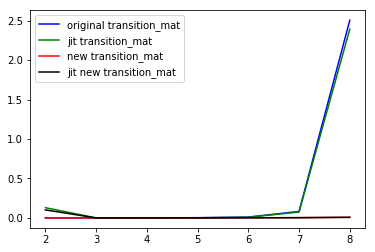

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.arange(2,9),times[0,:],color = "blue",label = "original transition_mat")
plt.plot(np.arange(2,9),times[1,:],color = "green",label = "jit transition_mat")
plt.plot(np.arange(2,9),times[2,:],color = "red",label = "new transition_mat")
plt.plot(np.arange(2,9),times[3,:],color = "black",label = "jit new transition_mat")
plt.legend(loc='upper left')
plt.show()

In [11]:
def gofm(inpt,kbar):
    """
    A function that calculates all the possible volatility states
    """
    m0 = inpt[1]
    m1 = 2-m0
    kbar2 = 2**kbar
    g_m1 = np.arange(kbar2)
    g_m = np.zeros(kbar2)
    
    for i in range(kbar2):
        g =1
        for j in range(kbar):
            if np.bitwise_and(g_m1[i],(2**j))!=0:
                g = g*m1
            else:
                g = g*m0
        g_m[i] = g
    return(np.sqrt(g_m))
            

def MSM_likelihood(inpt,kbar,data,A_template,estim_flag,nargout =1):
    if not hasattr(inpt,"__len__"):
        inpt = [estim_flag[0],inpt,estim_flag[1],estim_flag[2]]
        
    sigma = inpt[3]/np.sqrt(252)
    k2 = 2**kbar
    A = transition_mat(A_template.copy(),inpt,kbar)
    g_m = gofm(inpt,kbar)
    T = len(data)
    pi_mat = np.zeros((T+1,k2))
    LLs = np.zeros(T)
    pi_mat[0,:] = (1/k2)*np.ones((1,k2))
    """
    Likelihood Algorithm
    """
    pa = (2*np.pi)**(-0.5)
    s = sigma*g_m
    w_t = data 
    w_t = pa*np.exp(-0.5*((w_t/s)**2))/s
    w_t = w_t + 1e-16

    for t in range(T):
        
        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C) # log
        if np.isclose(ft,0):
            pi_mat[t+1,1]=1
        else:
            pi_mat[t+1,:] = C/ft
        LLs[t] = np.log(np.dot(w_t[t,:],piA))
        
    LL = -np.sum(LLs)
    if np.any(np.isinf(LLs)):
        print("Log-likelihood is inf. Probably due to all zeros in pi_mat.")
    if nargout == 1:
        return(LL)
    else:
        return(LL,LLs)

In [12]:
def MSM_starting_values(data,startingvals,kbar,A_template):
    if startingvals is None:
        print("No starting values entered: Using grid-search")

        b = np.array([1.5,3,6,20])
        lb = len(b)
        g = np.array([.1,.5,.9])
        lg = len(g)
        sigma = np.std(data)*np.sqrt(252)
        output_parameters = np.zeros(((lb*lg),3))
        LLs = np.zeros((lb*lg))
        m0_lower = 1.2
        m0_upper = 1.8
        idx = 0
        for i in range(lb):
            for j in range(lg):
                xopt,fval,ierr,numfunc = scipy.optimize.fminbound(MSM_likelihood,
                                                 x1 = m0_lower,x2 = m0_upper,xtol = 1e-3,
                                                 args = (kbar,data,A_template,[b[i],g[j],sigma]),full_output = True)
                m0,LL = xopt,fval
                output_parameters[idx,:] = b[i],m0,g[j]
                LLs[idx] = LL
                idx +=1
        idx = np.argsort(LLs)
        LLs = np.sort(LLs)
        startingvals = output_parameters[idx[0],:].tolist()+[sigma]
        output_parameters = output_parameters[idx,:]
        return(startingvals,LLs,output_parameters)

In [13]:
def MSM_modified(data,kbar,startingvals):
        A_template = T_mat_template(kbar)
        startingvals, LLs,ordered_parameters = MSM_starting_values(data,startingvals,kbar,A_template)
        bnds = ((1,50),(1,1.99),(1e-3,0.999999),(1e-4,5))
        minimizer_kwargs = dict(method = "L-BFGS-B",bounds = bnds,args = (kbar,dat,A_template,None))
        res = scipy.optimize.basinhopping(MSM_likelihood,x0 = startingvals,minimizer_kwargs = minimizer_kwargs,niter = 3)
        parameters,LL,niters,output = res.x,res.fun,res.nit,res.message
        LL, LLs = MSM_likelihood(parameters,kbar,data,A_template,None,2)
        LL = -LL
        
        return(LL,LLs,parameters)